In [2]:
# ----------------------------------------------------------
# Kidney Disease Prediction: Multi-Model Evaluation Pipeline
# ----------------------------------------------------------
# This notebook performs complete data preprocessing, trains
# multiple machine learning models, evaluates their performance,
# and exports the most accurate model.
# ----------------------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style='whitegrid')


In [3]:
# Load and inspect the dataset
df = pd.read_csv("kidney_disease.csv")
df.columns = df.columns.str.lower().str.strip()
print("Initial dataset shape:", df.shape)
print("Column names:", df.columns.tolist())

# Replace '?' placeholders with NaN for uniform handling of missing values
df.replace('?', np.nan, inplace=True)


Initial dataset shape: (400, 26)
Column names: ['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']


In [4]:
# Convert numerical columns from object to float
num_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod',
            'pot', 'hemo', 'pcv', 'wc', 'rc']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing numeric values with median strategy
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Handle categorical data
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('classification')  # Exclude target
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # Replace missing with mode
    df[col] = LabelEncoder().fit_transform(df[col])  # Encode categories


In [5]:
# Clean and encode the target variable
df['classification'] = df['classification'].str.strip().map({'ckd': 1, 'notckd': 0, 'ckd\t': 1}).astype(int)
print("Target variable encoded successfully.")


Target variable encoded successfully.


In [6]:
# Separate features and target
X = df.drop('classification', axis=1)
y = df['classification']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for better model convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
# Initialize models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB()
}

results = {}
best_model = None
best_acc = 0

# Evaluate all models
print("----- Model Evaluation Start -----")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    
    if name=="Naive Bayes":
        best_acc = acc
        best_model = model
        best_model_name = name
print("----- Model Evaluation Complete -----\n")


----- Model Evaluation Start -----
Logistic Regression Accuracy: 1.0000
Decision Tree Accuracy: 1.0000
Random Forest Accuracy: 1.0000
SVM Accuracy: 1.0000
Naive Bayes Accuracy: 0.9875
----- Model Evaluation Complete -----



In [16]:
# Display results
print("Model Accuracy Comparison:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Save the best performing model
print(f"\nBest Model: {best_model_name} with accuracy {best_acc:.4f}")
with open("best_kidney_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("Best model saved to 'best_kidney_model.pkl'")


Model Accuracy Comparison:
Logistic Regression: 1.0000
Decision Tree: 1.0000
Random Forest: 1.0000
SVM: 1.0000
Naive Bayes: 0.9875

Best Model: Naive Bayes with accuracy 0.9875
Best model saved to 'best_kidney_model.pkl'



Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



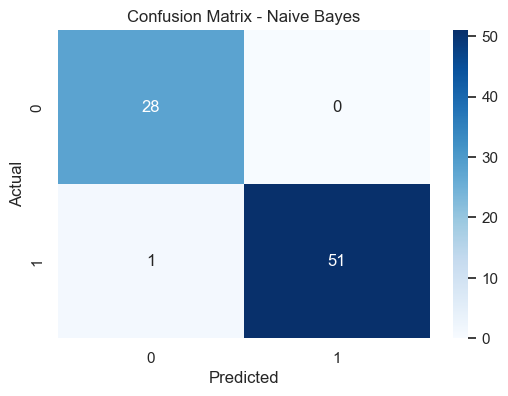

In [17]:
# Generate predictions and report
y_pred_best = best_model.predict(X_test)
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))

# Display confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
